# Initial imports

In [39]:
%pip install ipython-autotime  --upgrade

time: 11.3 s (started: 2023-07-15 18:11:32 +00:00)


In [40]:
from google.colab import drive, files
import joblib
import pandas as pd
drive.mount('/content/drive', force_remount=True)
%load_ext autotime

Mounted at /content/drive
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 3.97 s (started: 2023-07-15 18:11:43 +00:00)


In [41]:
dataset = joblib.load("/content/drive/MyDrive/datasets/loterias/loterias-lotofacil.pkl")
#dataset['Data_Sorteio'] = pd.to_datetime(dataset['Data_Sorteio'], format="%d/%m/%Y")
#dataset = dataset.set_index('Data_Sorteio')
dataset = dataset.drop(['Data_Sorteio'], axis=1)

time: 53.9 ms (started: 2023-07-15 18:11:47 +00:00)


# EDA

In [42]:
dataset

,Bola1,Bola2,Bola3,Bola4,Bola5,Bola6,Bola7,Bola8,Bola9,Bola10,Bola11,Bola12,Bola13,Bola14,Bola15
0,2.0,3.0,5.0,6.0,9.0,10.0,11.0,13.0,14.0,16.0,18.0,20.0,23.0,24.0,25.0
1,1.0,4.0,5.0,6.0,7.0,9.0,11.0,12.0,13.0,15.0,16.0,19.0,20.0,23.0,24.0
2,1.0,4.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,14.0,16.0,17.0,20.0,23.0,24.0
3,1.0,2.0,4.0,5.0,8.0,10.0,12.0,13.0,16.0,17.0,18.0,19.0,23.0,24.0,25.0
4,1.0,2.0,4.0,8.0,9.0,11.0,12.0,13.0,15.0,16.0,19.0,20.0,23.0,24.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2706,1.0,2.0,4.0,5.0,8.0,9.0,10.0,11.0,14.0,15.0,16.0,17.0,18.0,21.0,25.0
2707,1.0,2.0,3.0,5.0,6.0,13.0,14.0,16.0,18.0,19.0,21.0,22.0,23.0,24.0,25.0
2708,1.0,2.0,3.0,5.0,9.0,10.0,11.0,12.0,13.0,19.0,21.0,22.0,23.0,24.0,25.0
2709,1.0,2.0,3.0,4.0,7.0,10.0,11.0,12.0,13.0,14.0,16.0,17.0,20.0,24.0,25.0


time: 145 ms (started: 2023-07-15 18:11:47 +00:00)


In [43]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2711 entries, 0 to 2710
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Bola1   2711 non-null   float64
 1   Bola2   2711 non-null   float64
 2   Bola3   2711 non-null   float64
 3   Bola4   2711 non-null   float64
 4   Bola5   2711 non-null   float64
 5   Bola6   2711 non-null   float64
 6   Bola7   2711 non-null   float64
 7   Bola8   2711 non-null   float64
 8   Bola9   2711 non-null   float64
 9   Bola10  2711 non-null   float64
 10  Bola11  2711 non-null   float64
 11  Bola12  2711 non-null   float64
 12  Bola13  2711 non-null   float64
 13  Bola14  2711 non-null   float64
 14  Bola15  2711 non-null   float64
dtypes: float64(15)
memory usage: 317.8 KB
time: 17.8 ms (started: 2023-07-15 18:11:47 +00:00)


In [44]:
dataset.describe()

,Bola1,Bola2,Bola3,Bola4,Bola5,Bola6,Bola7,Bola8,Bola9,Bola10,Bola11,Bola12,Bola13,Bola14,Bola15
count,2711.000000,2711.000000,2711.000000,2711.000000,2711.000000,2711.000000,2711.000000,2711.000000,2711.00000,2711.000000,2711.000000,2711.000000,2711.000000,2711.000000,2711.000000
mean,1.628181,3.265585,4.883069,6.524161,8.161933,9.791959,11.388049,13.018812,14.61564,16.257838,17.910365,19.546293,21.174105,22.788639,24.400221
std,0.929867,1.303809,1.541305,1.710632,1.815667,1.860114,1.886422,1.908810,1.92397,1.876124,1.780503,1.649549,1.482969,1.267809,0.943566
min,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.00000,10.000000,12.000000,13.000000,15.000000,17.000000,18.000000
25%,1.000000,2.000000,4.000000,5.000000,7.000000,8.000000,10.000000,12.000000,13.00000,15.000000,17.000000,18.000000,20.000000,22.000000,24.000000
50%,1.000000,3.000000,5.000000,6.000000,8.000000,10.000000,11.000000,13.000000,15.00000,16.000000,18.000000,20.000000,21.000000,23.000000,25.000000
75%,2.000000,4.000000,6.000000,8.000000,9.000000,11.000000,13.000000,14.000000,16.00000,18.000000,19.000000,21.000000,22.000000,24.000000,25.000000
max,7.000000,9.000000,12.000000,13.000000,14.000000,16.000000,17.000000,18.000000,19.00000,20.000000,21.000000,22.000000,23.000000,24.000000,25.000000


time: 96.2 ms (started: 2023-07-15 18:11:48 +00:00)


# Feature engineering

In [45]:
from sklearn.base     import BaseEstimator, TransformerMixin
from sklearn.compose  import ColumnTransformer
from sklearn.pipeline import Pipeline

import itertools
import numpy as np

time: 747 µs (started: 2023-07-15 18:11:48 +00:00)


In [46]:
class RepeatedOne(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X, y)

  def match_numbers(self, X):
      raffle_x = set(X.iloc[:15])
      raffle_y = set(X.iloc[15:])
      return len(raffle_x.intersection(raffle_y))

  def transform(self, X, y=None):
    X_ = X.copy()
    for name in X_.columns:
      X_['lag1_' + name] = X_[name].shift(1)
    X['repeated'] = X_.apply(self.match_numbers, axis=1)
    return X



pp_repeated = Pipeline(steps=[('repeated', RepeatedOne())])

time: 5.41 ms (started: 2023-07-15 18:11:48 +00:00)


In [47]:
class EvenOdd(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X, y)

  def get_feature_names_out(self):
    pass

  def even_amount(self, raffle):
    raffle_size = 15
    even = itertools.filterfalse(lambda x: x % 2 != 0, raffle.iloc[:raffle_size])
    return len(list(even))

  def transform(self, X, y=None):
    X = X.copy()
    raffle_size = 15
    X['even_amount'] = X.apply(self.even_amount, axis=1)
    X['odd_amount']  = raffle_size - X['even_amount']
    return X



pp_evenodd = Pipeline(steps=[('evenodd', EvenOdd())])

time: 1.5 ms (started: 2023-07-15 18:11:48 +00:00)


In [48]:
class Quartiles(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X, y)

  def get_feature_names_out(self):
    pass

  def transform(self, X, y=None):
    X_ = X.iloc[:, 0: 15].copy()
    X['quartile_1_5']   = X_.apply(lambda y: ((y >= 1) & (y <= 5)).sum(), axis=1)
    X['quartile_6_10']  = X_.apply(lambda y: ((y >= 6) & (y <= 10)).sum(), axis=1)
    X['quartile_11_15'] = X_.apply(lambda y: ((y >= 11) & (y <= 15)).sum(), axis=1)
    X['quartile_16_20'] = X_.apply(lambda y: ((y >= 16) & (y <= 20)).sum(), axis=1)
    X['quartile_21_25'] = X_.apply(lambda y: ((y >= 21) & (y <=25)).sum(), axis=1)
    return X



pp_quartiles = Pipeline(steps=[('quartiles', Quartiles())])

time: 1.92 ms (started: 2023-07-15 18:11:48 +00:00)


In [49]:
class RaffleRemover(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X, y)

  def transform(self, X, y=None):
    return X.iloc[:, 15:]



pp_raffleremover = Pipeline(steps=[('raffleremover', RaffleRemover())])

time: 3.69 ms (started: 2023-07-15 18:11:48 +00:00)


## Pipeline completo

In [50]:
steps = [('pp_repeated', pp_repeated),
         ('pp_evenodd', pp_evenodd),
         ('pp_quartiles', pp_quartiles),
         ('pp_raffleremover', pp_raffleremover)]

pipeline_full = Pipeline(steps=steps)
dataset_ = pipeline_full.fit_transform(dataset)
dataset_.head()

,Bola15,repeated,even_amount,odd_amount,quartile_1_5,quartile_6_10,quartile_11_15,quartile_16_20,quartile_21_25
0,25.0,0,8,7,3,3,3,3,3
1,24.0,9,6,9,3,3,4,3,2
2,24.0,11,9,6,2,5,3,3,2
3,25.0,9,8,7,4,2,2,4,3
4,25.0,12,7,8,3,2,4,3,3


time: 5.28 s (started: 2023-07-15 18:11:27 +00:00)


,repeated,even_amount,odd_amount,quartile_1_5,quartile_6_10,quartile_11_15,quartile_16_20,quartile_21_25
0,0,8,7,3,3,3,3,3
1,9,6,9,3,3,4,3,2
2,11,9,6,2,5,3,3,2
3,9,8,7,4,2,2,4,3
4,11,7,8,3,2,4,3,3


time: 7.74 s (started: 2023-07-15 18:11:48 +00:00)


# Data visualization

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

time: 1.59 ms (started: 2023-07-15 18:11:56 +00:00)


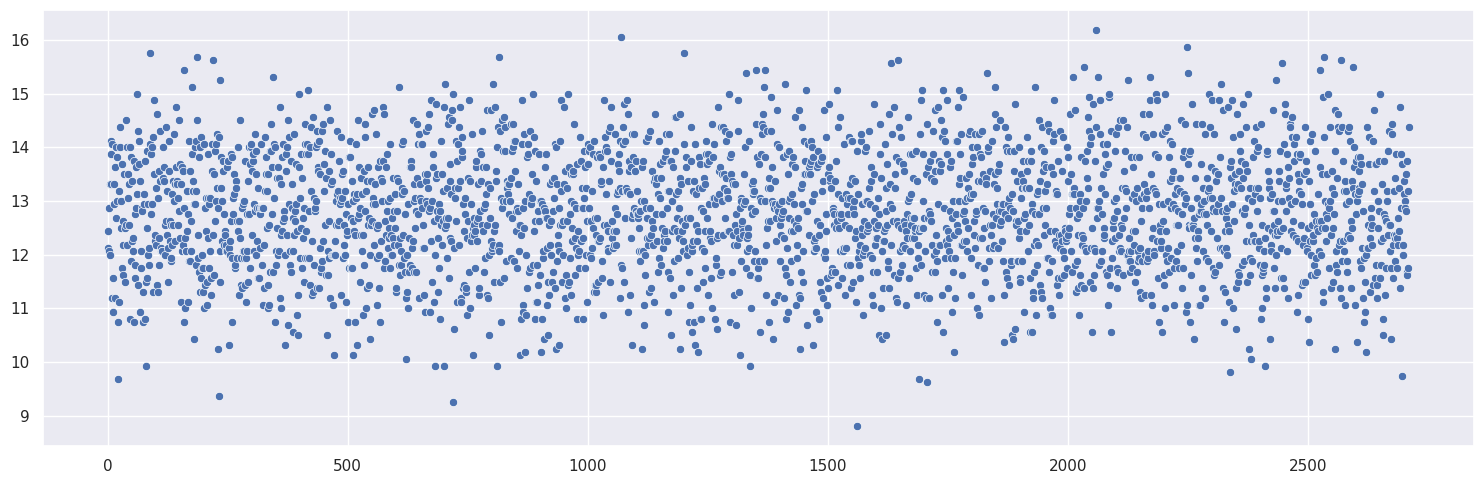

time: 423 ms (started: 2023-07-15 18:11:56 +00:00)


In [52]:
sns.set(rc={'figure.figsize':(15, 5)})
sns.scatterplot(dataset.mean(axis=1))
plt.tight_layout()
plt.show()

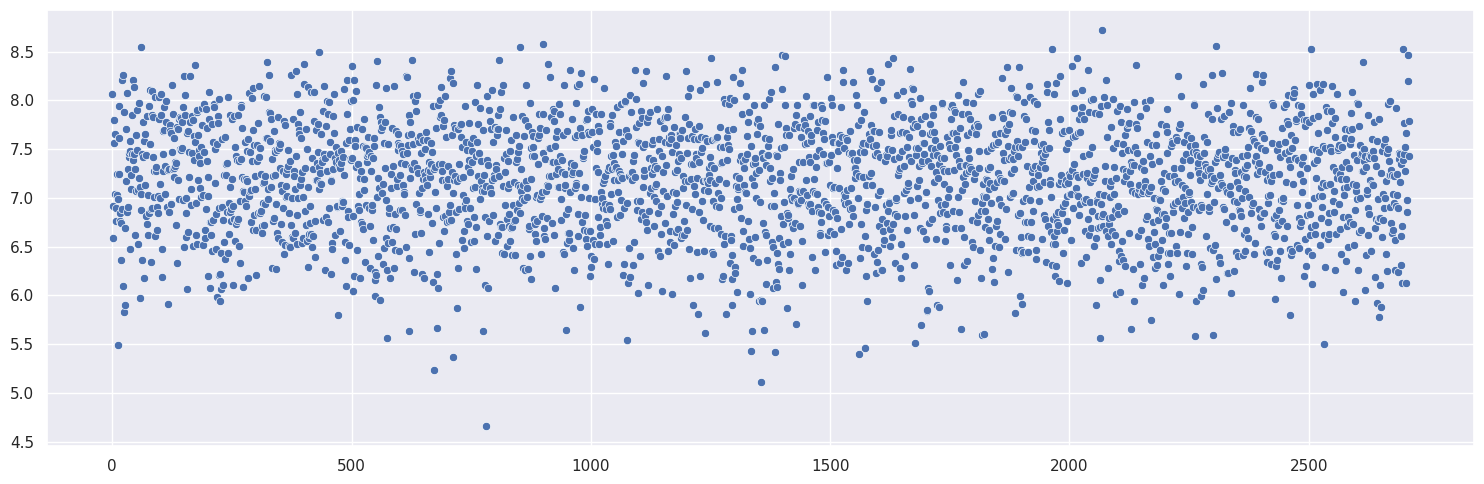

time: 441 ms (started: 2023-07-15 18:11:56 +00:00)


In [53]:
sns.set(rc={'figure.figsize':(15, 5)})
sns.scatterplot(dataset.std(axis=1))
plt.tight_layout()
plt.show()

KeyError: ignored

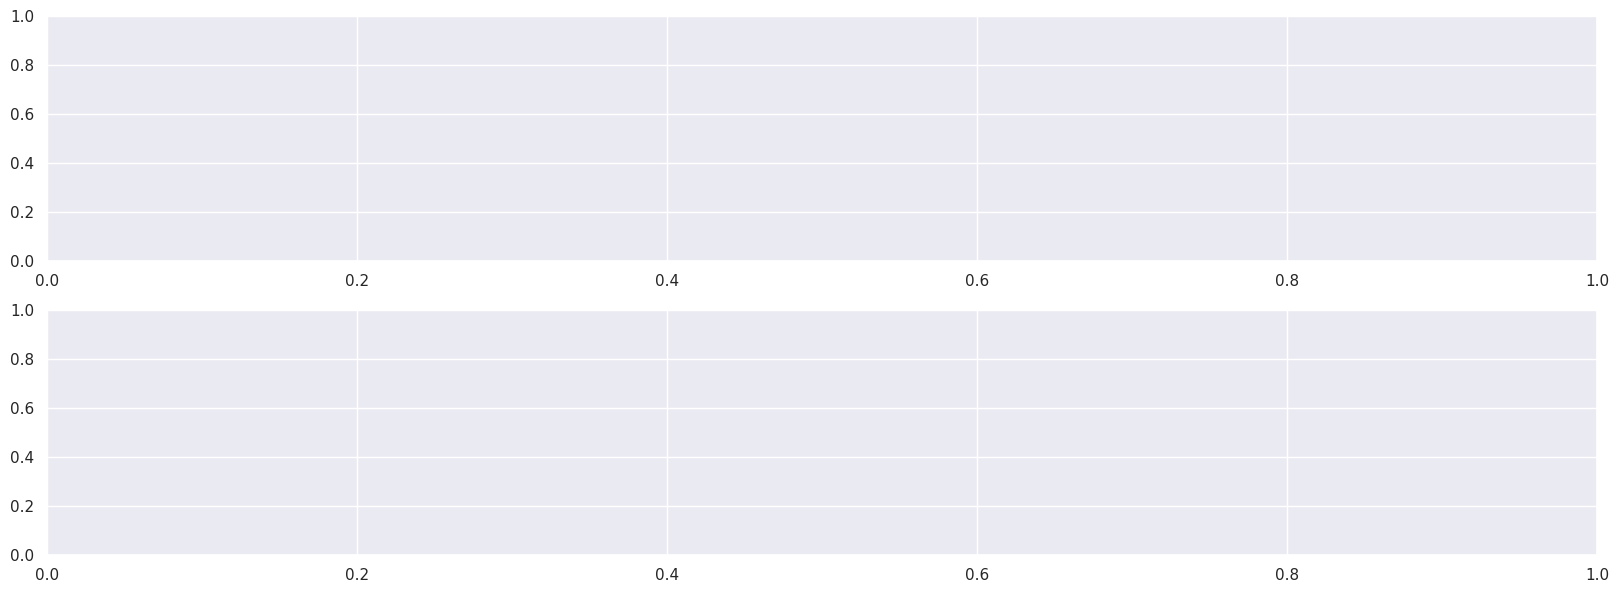

time: 759 ms (started: 2023-07-15 18:11:56 +00:00)


In [54]:
fig, axis = plt.subplots(2, 1, figsize=(20, 7))
axis = axis.ravel()
sns.lineplot(dataset['even_amount'], ax=axis[0])
sns.lineplot(dataset['odd_amount'], ax=axis[1])
plt.tight_layout()
plt.show()

# Train/Test split

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
tss = TimeSeriesSplit(n_splits=2, test_size=200, gap=1)
folds = tss.split(dataset)

next(folds)
train_indexes, test_indexes = next(folds) # só o último fold me interessa pois é o maior

train_set = dataset.iloc[train_indexes]
test_set  = dataset.iloc[test_indexes]

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(15, 5), sharex=True)

axs.axvline(test_set.index.min(), color='black', ls='--')
sns.lineplot(x=train_set.index, y=train_set['even_amount'], ax=axs)
sns.lineplot(x=test_set.index, y=test_set['even_amount'], ax=axs)

plt.tight_layout()
plt.show()